# Vanilla vs Hardt

## Imports and Definitions

In [1]:
import os
import torch
import numpy as np
import cvxpy as cp
import pandas as pd

from lib.StrategicModel import StrategicModel
import DataGeneration as data
#import Presentation

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

PATH = "./Results/vanilla_vs_hardt_orig"
if not os.path.exists(PATH):
    os.makedirs(PATH)

## Data Loading

In [2]:
X, Y = data.load_spam_data()
X, Y, Xval, Yval, Xtest, Ytest = data.split_validation_test(X, Y)

## Training

In [3]:
x_dim = len(X[0])
epochs = 16
batch_size = 128

v = torch.tensor([-1,-1,-1,-1,-1,-1,-1,1,1,0.1,1,0.1,0.1,1,0.1])

small_eps = 0.04
epsilons = [small_eps, 0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 0.95, 0.99]

In [4]:
results = {
    "epsilons": [],
    "benchmark": [],
    "SERM": [],
    "blind": [],
    "Hardt": []
}

print(f"---------- Training Hardt et al's model (strategic with eps={small_eps}) ----------")
torch.manual_seed(0)
np.random.seed(0)

model_name = "strategic_approx"
strategic_model_approx = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v, "epsilon": small_eps, "scale":0.35}, eval_slope = 4, strategic=True)
strategic_model_approx.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 2e-1}, epochs=epochs, verbose="batches", path=PATH, model_name=model_name)

for eps in epsilons:
    print(f"------------------------- {eps} -------------------------")
    
    # Non-strategic classification
    print(f"---------- Training non-strategically with epsilon={eps} ----------")
    torch.manual_seed(0)
    np.random.seed(0)
    
    model_name = f"non_strategic_{eps}"
    non_strategic_model = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v, "epsilon": eps, "scale":0.35}, eval_slope = 4, strategic=False)
    non_strategic_model.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 2e-1}, epochs=epochs, verbose="batches", path=PATH, model_name=model_name)
    
    non_strategic_model = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v, "epsilon": eps, "scale":0.35}, eval_slope = 4, strategic=False)
    non_strategic_model.load_model(PATH, model_name)
    non_strategic_model.normalize_parameters()
    
    # Strategic classification
    print(f"---------- Training strategically with epsilon={eps} ----------")
    torch.manual_seed(0)
    np.random.seed(0)
    
    model_name = f"strategic_real_{eps}"
    strategic_model_real = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v, "epsilon": eps, "scale":0.35}, eval_slope = 4, strategic=True)
    strategic_model_real.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 2e-1}, epochs=epochs, verbose="batches", path=PATH, model_name=model_name)
    
    strategic_model_real = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v, "epsilon": eps, "scale":0.35}, eval_slope = 4, strategic=True)
    strategic_model_real.load_model(PATH, model_name)
    
    # Approximate strategic classification (set evaluation epsilon to eps)
    model_name = "strategic_approx"
    strategic_model_approx = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v, "epsilon": eps, "scale":0.35}, eval_slope = 4, strategic=True)
    strategic_model_approx.load_model(PATH, model_name)
    
    # Calculate results
    print("---------- Calculating results ----------")
    results["epsilons"].append(eps)
    # Non-strategic model & non-strategic data - Benchmark
    results["benchmark"].append(non_strategic_model.evaluate(Xtest, Ytest, strategic_data=False))
    # Approx strategic model & strategic data - Hardt et al
    results["Hardt"].append(strategic_model_approx.evaluate(Xtest, Ytest, strategic_data=True))
    # Real strategic model & strategic data - SERM
    results["SERM"].append(strategic_model_real.evaluate(Xtest, Ytest, strategic_data=True))
    # Non-strategic model & strategic data - Blind
    results["blind"].append(non_strategic_model.evaluate(Xtest, Ytest, strategic_data=True))
    pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

---------- Training Hardt et al's model (strategic with eps=0.04) ----------
Starting epoch 001 / 016.
  Ended batch 001 / 034 | loss: 0.96494 | error: 0.46094
  Ended batch 002 / 034 | loss: 0.99688 | error: 0.48438
  Ended batch 003 / 034 | loss: 1.00848 | error: 0.52344
  Ended batch 004 / 034 | loss: 1.01666 | error: 0.52344
  Ended batch 005 / 034 | loss: 0.99586 | error: 0.47656
  Ended batch 006 / 034 | loss: 0.91422 | error: 0.46875
  Ended batch 007 / 034 | loss: 1.08640 | error: 0.58594
  Ended batch 008 / 034 | loss: 0.91806 | error: 0.31250
  Ended batch 009 / 034 | loss: 0.85547 | error: 0.46094
  Ended batch 010 / 034 | loss: 0.84307 | error: 0.42188
  Ended batch 011 / 034 | loss: 0.88342 | error: 0.47656
  Ended batch 012 / 034 | loss: 1.20697 | error: 0.61719
  Ended batch 013 / 034 | loss: 0.86470 | error: 0.45312
  Ended batch 014 / 034 | loss: 0.85290 | error: 0.42188
  Ended batch 015 / 034 | loss: 0.85567 | error: 0.45312
  Ended batch 016 / 034 | loss: 0.77038 | 

C:\Users\mmakhlevich\Anaconda3\envs\SCMP_setup\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


  Ended batch 019 / 034 | loss: 0.74027 | error: 0.37500
  Ended batch 020 / 034 | loss: 0.94829 | error: 0.45312
  Ended batch 021 / 034 | loss: 0.91169 | error: 0.45312
  Ended batch 022 / 034 | loss: 0.70683 | error: 0.33594
  Ended batch 023 / 034 | loss: 0.70030 | error: 0.34375
  Ended batch 024 / 034 | loss: 0.75500 | error: 0.37500
  Ended batch 025 / 034 | loss: 0.80582 | error: 0.40625
  Ended batch 026 / 034 | loss: 0.84008 | error: 0.42188
  Ended batch 027 / 034 | loss: 0.66407 | error: 0.32031
  Ended batch 028 / 034 | loss: 0.78769 | error: 0.38281
  Ended batch 029 / 034 | loss: 0.59008 | error: 0.29688
  Ended batch 030 / 034 | loss: 0.68286 | error: 0.34375
  Ended batch 031 / 034 | loss: 0.75378 | error: 0.36719
  Ended batch 032 / 034 | loss: 0.83983 | error: 0.42188
  Ended batch 033 / 034 | loss: 0.71213 | error: 0.32031
  Ended batch 034 / 034 | loss: 0.82168 | error: 0.40909
  Finished training step, calculating validation loss and accuracy.
Ended epoch 001 / 01

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\mmakhlevich\Anaconda3\envs\SCMP_setup\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-bb6bc277937d>", line 40, in <module>
    strategic_model_real.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 2e-1}, epochs=epochs, verbose="batches", path=PATH, model_name=model_name)
  File "C:\Users\mmakhlevich\ModularStrategicClassification-develop\lib\StrategicModel.py", line 357, in fit
    Xbatch_opt, Ybatch_pred = self.forward(Xbatch, requires_grad=True)
  File "C:\Users\mmakhlevich\ModularStrategicClassification-develop\lib\StrategicModel.py", line 200, in forward
    X_opt = self.optimize_X(X, requires_grad=requires_grad)
  File "C:\Users\mmakhlevich\ModularStrategicClassification-develop\lib\StrategicModel.py", line 238, in optimize_X
    requires_grad=requires_grad)
  File "C:\Users\mmakhlevich\ModularStrategicCla

TypeError: object of type 'NoneType' has no len()

## Show Results

In [ ]:
#Presentation.show_vanilla_vs_hardt_results()

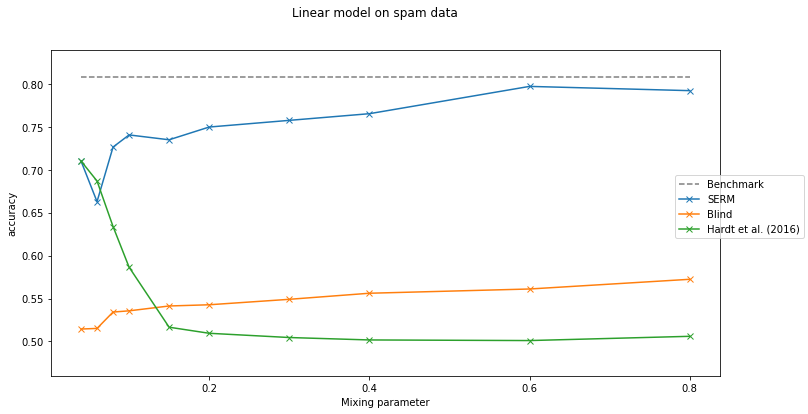

In [5]:
import matplotlib.pyplot as plt


results = pd.read_csv("Results/vanilla_vs_hardt_orig/results.csv")
epsilons = results["epsilons"].to_list()
benchmark = results["benchmark"].to_list()
SERM = results["SERM"].to_list()
blind = results["blind"].to_list()
Hardt = results["Hardt"].to_list()

fig, ax = plt.subplots(figsize=(12, 6))
_ = fig.suptitle("Linear model on spam data")

_ = ax.set_xlabel("Mixing parameter")
_ = ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
_ = ax.set_ylabel("accuracy")
_ = ax.set_ylim([0.46, 0.84])

_ = ax.plot(epsilons, benchmark, label="Benchmark", linestyle="--", color="tab:gray")
_ = ax.plot(epsilons, SERM, "-x", label="SERM")
_ = ax.plot(epsilons, blind, "-x", label="Blind")
_ = ax.plot(epsilons, Hardt, "-x", label="Hardt et al. (2016)")

lines, labels = ax.get_legend_handles_labels()    
_ = fig.legend(lines, labels, loc="right")